In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pprint import pprint
import pickle
import time
import datetime

In [2]:
# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
# from qiskit.tools.monitor import job_monitor
from qiskit.compiler import transpile
from qiskit.transpiler.passes import RemoveBarriers
import qiskit.quantum_info as qi

In [3]:
from kagome_trotter.circuits_initial import gate_initial_state
from kagome_trotter.circuits_1d_path import gate_path_triangle_parallel
from kagome_trotter.hamiltonian import Hamiltonian, make_H_Heisenberg_path
from kagome_trotter.backend_simulator import result_to_dms, make_dm_binary, hamiltonian_to_dm, DMExtended
from setting import *

In [4]:
dt = Parameter(r"$\Delta t$")
state_initial_dm = DMExtended(matrix=make_dm_binary(str_binary=state_initial,
                                                    endian_binary="big",
                                                    endian_dm="little")) ### make the density matrix for the initial state

H_Heisenberg = make_H_Heisenberg_path(num_qubits=num_qubits) ### create Heisenberg Hamiltonian in a dictionary format
matrix_Heisenberg = hamiltonian_to_dm(hamiltonian=H_Heisenberg) ### convert Heisenberg Hamiltonian to its matrix form

U_Heisenberg = DMExtended(sp.linalg.expm(-1.0j * matrix_Heisenberg * time_evolution)) ### prepare the unitary matrix of the Heisenberg Hamiltonian

state_target_dm = state_initial_dm.apply_unitary(U_Heisenberg) ### apply the unitary evolution to the density matrix
state_target_dm.is_valid()

True

In [5]:
fidelities = []
nums_cnots = []

print("trotter step list: ", num_steps_list)
for num_steps in num_steps_list:
    
    print("trotter steps: ", num_steps)
    t1 = time.perf_counter()
    
    # Initialize quantum circuit for 3 qubits
    qc = QuantumCircuit(num_qubits)

    # Prepare initial state
    qc.compose(gate_initial_state(state_initial=state_initial),
               qubits=list(range(num_qubits)),
               inplace=True,)
    
    qc.append(instruction=gate_path_triangle_parallel(num_qubits=num_qubits,
                                             num_steps=num_steps // 4, ###!
                                             dt=dt * 2, ###!
                                             type_H_eff=type_H_eff_triangle,
                                             to_instruction=False,
                                             add_barrier=False,
                                          ),
              qargs=list(range(num_qubits)),
             )

    # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
    qc = qc.assign_parameters({dt: time_evolution / num_steps})
    qc_t3 = transpile(RemoveBarriers()(qc), optimization_level=3, basis_gates=["sx", "cx", "rz"])
    qc_t3.save_density_matrix()
    
    ### execute circuits
    result_raw = simulator_ideal.run(qc_t3,
                                     shots=0,
                                    ).result()
    dm_raw = result_to_dms(result=result_raw,
                           endian_result="little",
                           endian_dm="little",
                          )[0]

    fidelities.append(qi.state_fidelity(dm_raw, state_target_dm))
    nums_cnots.append(qc_t3.count_ops().get("cx"))
    
    t2 = time.perf_counter()
    print("raw state tomography fidelity = {:.4f}".format(fidelities[-1]))
    print("number of CNOT gates:", qc_t3.count_ops().get("cx"))
    print("time:", t2 - t1)
    print()

trotter step list:  [20, 60, 100, 140, 180, 220, 260, 300, 340, 380, 420, 460]
trotter steps:  20
raw state tomography fidelity = 0.1893
number of CNOT gates: 274
time: 1.4016527920030057

trotter steps:  60
raw state tomography fidelity = 0.9604
number of CNOT gates: 814
time: 1.2153621250763535

trotter steps:  100
raw state tomography fidelity = 0.9891
number of CNOT gates: 1354
time: 2.3588337500113994

trotter steps:  140
raw state tomography fidelity = 0.9949
number of CNOT gates: 1894
time: 4.176490541081876

trotter steps:  180
raw state tomography fidelity = 0.9970
number of CNOT gates: 2434
time: 6.110509624937549

trotter steps:  220
raw state tomography fidelity = 0.9980
number of CNOT gates: 2974
time: 8.494164541130885

trotter steps:  260
raw state tomography fidelity = 0.9986
number of CNOT gates: 3514
time: 8.587003791937605

trotter steps:  300
raw state tomography fidelity = 0.9990
number of CNOT gates: 4054
time: 9.804219499928877

trotter steps:  340
raw state tomo

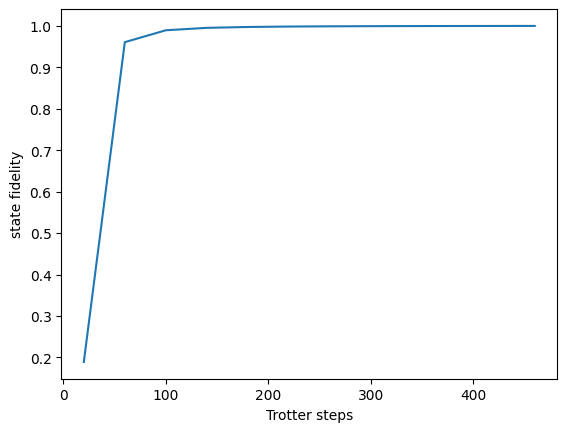

In [6]:
plt.plot(num_steps_list, fidelities)
plt.xlabel("Trotter steps")
plt.ylabel("state fidelity")
plt.show()

In [7]:
with open("run_triangle_parallel.pkl", "wb") as f:
    pickle.dump(obj={"num_steps_list": num_steps_list, 
                     "fidelities": fidelities, 
                     "nums_cnots": nums_cnots},
                file=f)

62


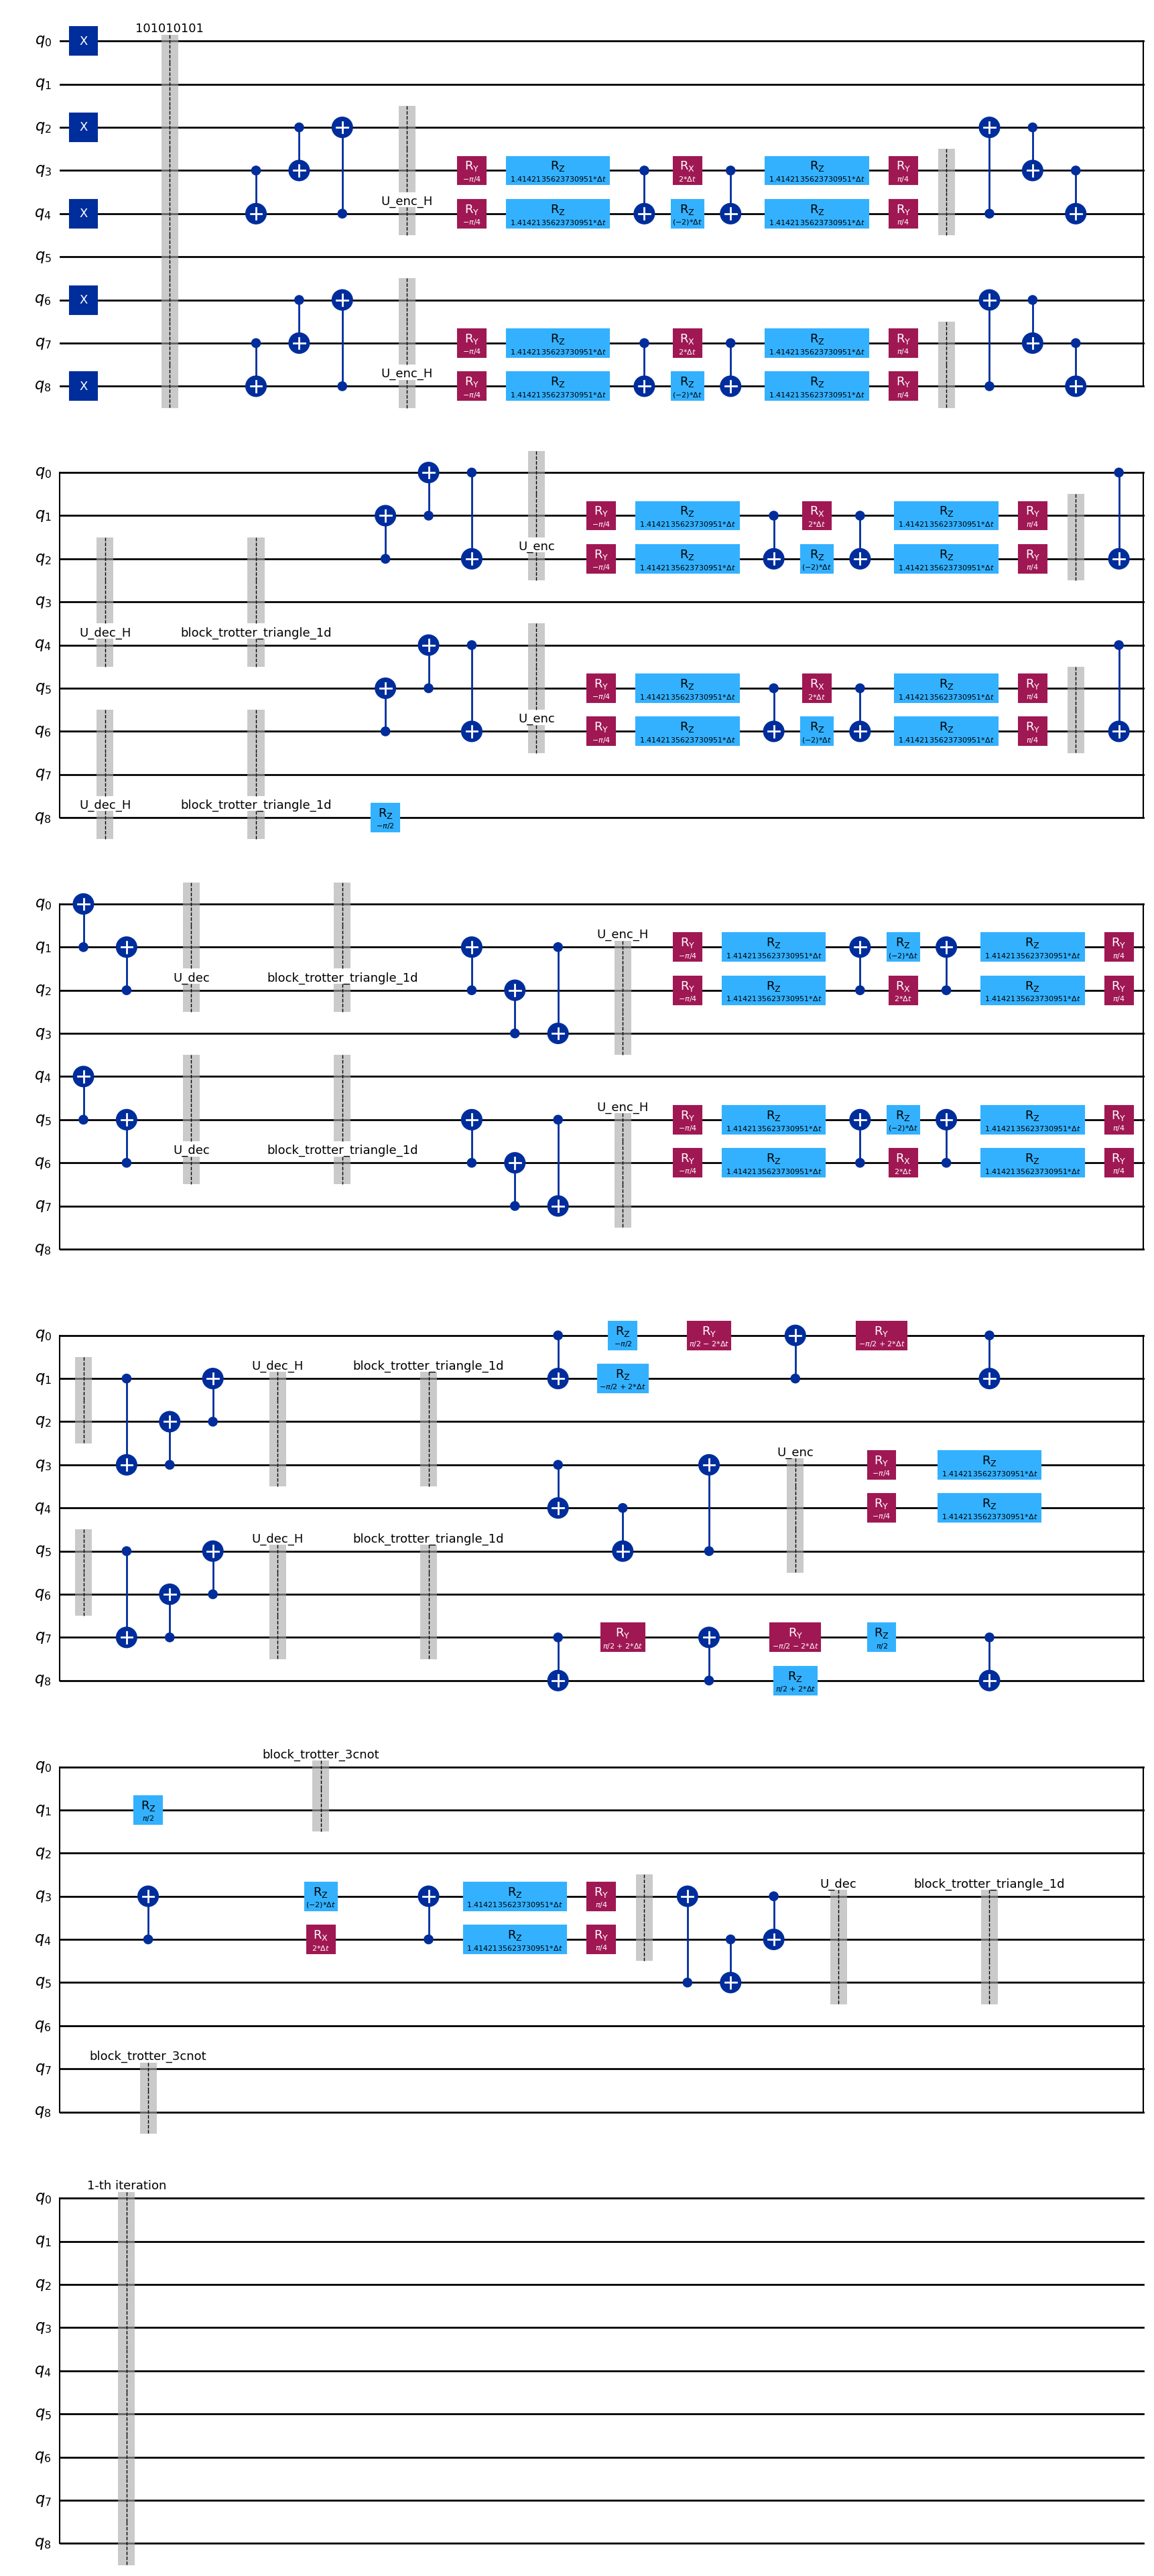

In [8]:
qc = QuantumCircuit(num_qubits)
qc.compose(gate_initial_state(state_initial=state_initial,
                              to_instruction=False,
                              add_barrier=True,),
            qubits=list(range(num_qubits)),
            inplace=True,)

qc.compose(gate_path_triangle_parallel(num_qubits=num_qubits,
                                            num_steps=1, ###!
                                            dt=dt,
                                            type_H_eff=type_H_eff_triangle,
                                            to_instruction=False,
                                            add_barrier=True,
                                        ),
            qubits=list(range(num_qubits)),
            inplace=True,
            )
print(qc.count_ops().get("cx"))
qc.draw("mpl")

58


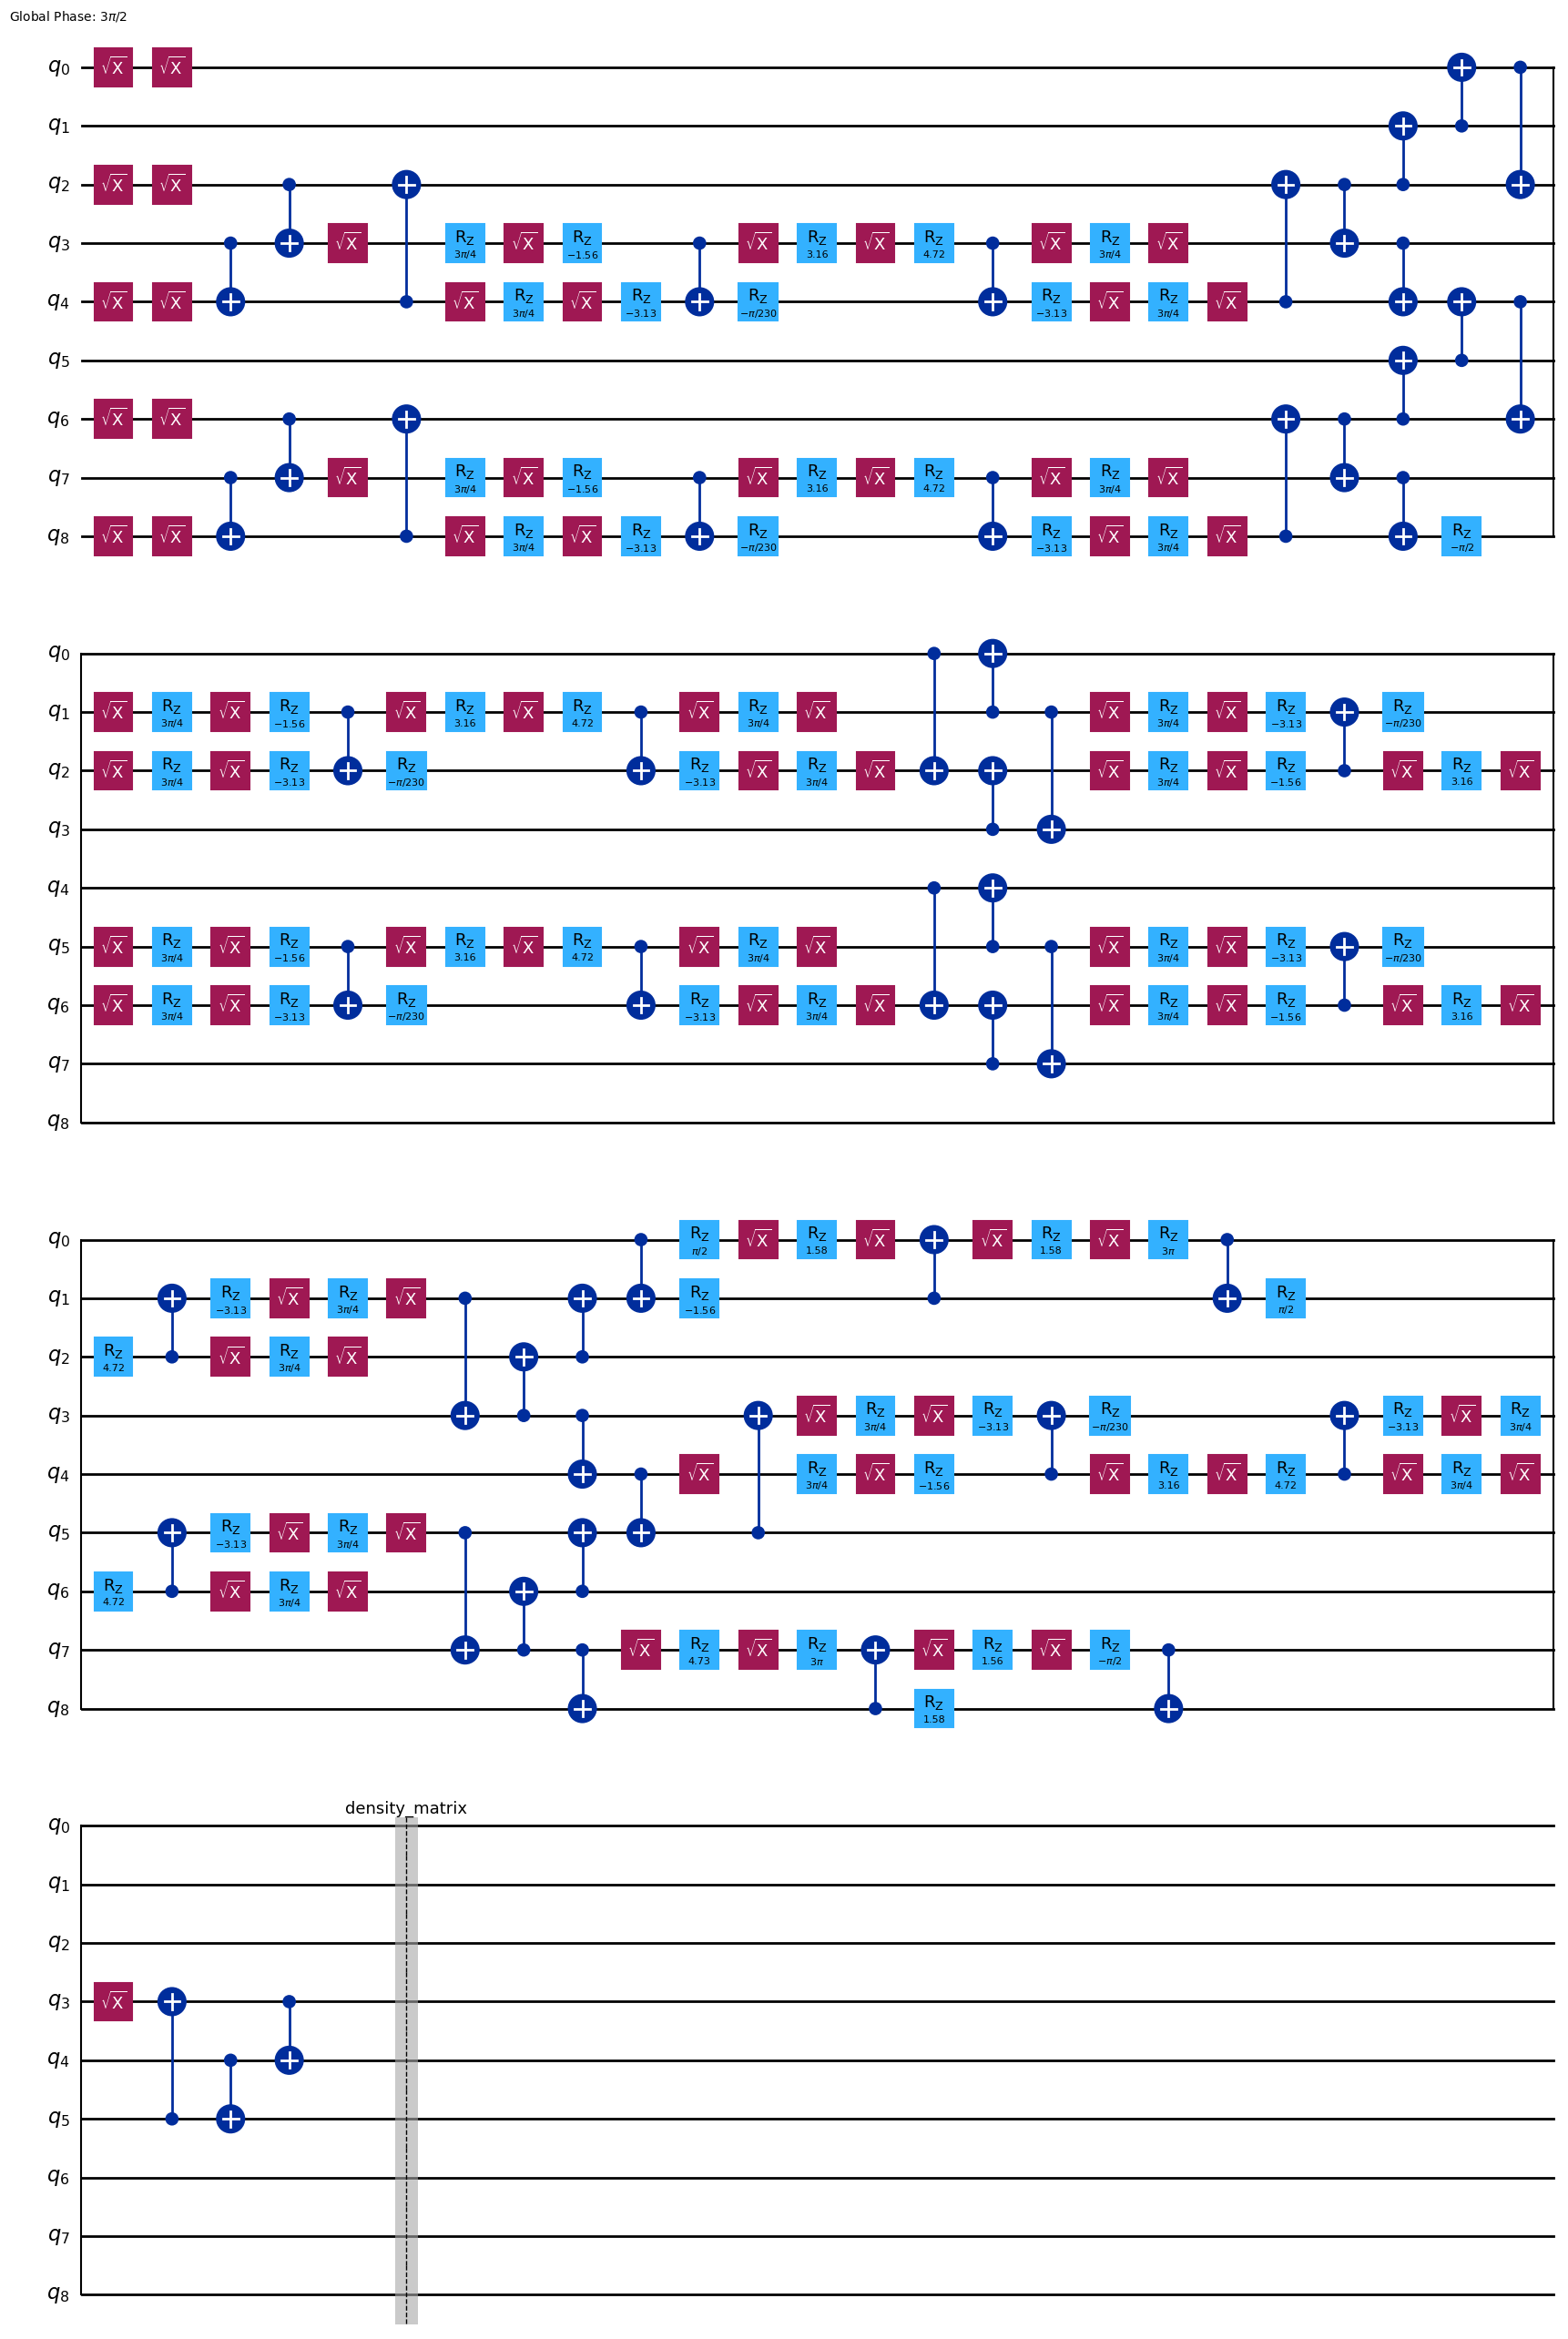

In [9]:
qc = QuantumCircuit(num_qubits)

# Prepare initial state
qc.compose(gate_initial_state(state_initial=state_initial),
            qubits=list(range(num_qubits)),
            inplace=True,)

qc.append(instruction=gate_path_triangle_parallel(num_qubits=num_qubits,
                                            num_steps=1, ###!
                                            dt=dt,
                                            type_H_eff=type_H_eff_triangle,
                                            to_instruction=False,
                                            add_barrier=False,
                                        ),
            qargs=list(range(num_qubits)),
            )

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
qc = qc.assign_parameters({dt: time_evolution / num_steps})
qc_t3 = transpile(RemoveBarriers()(qc), optimization_level=3, basis_gates=["sx", "cx", "rz"])
# qc_t3 = transpile(qc, optimization_level=3, basis_gates=["sx", "cx", "rz"])
qc_t3.save_density_matrix()
print(qc_t3.count_ops().get("cx"))
qc_t3.draw("mpl")

112


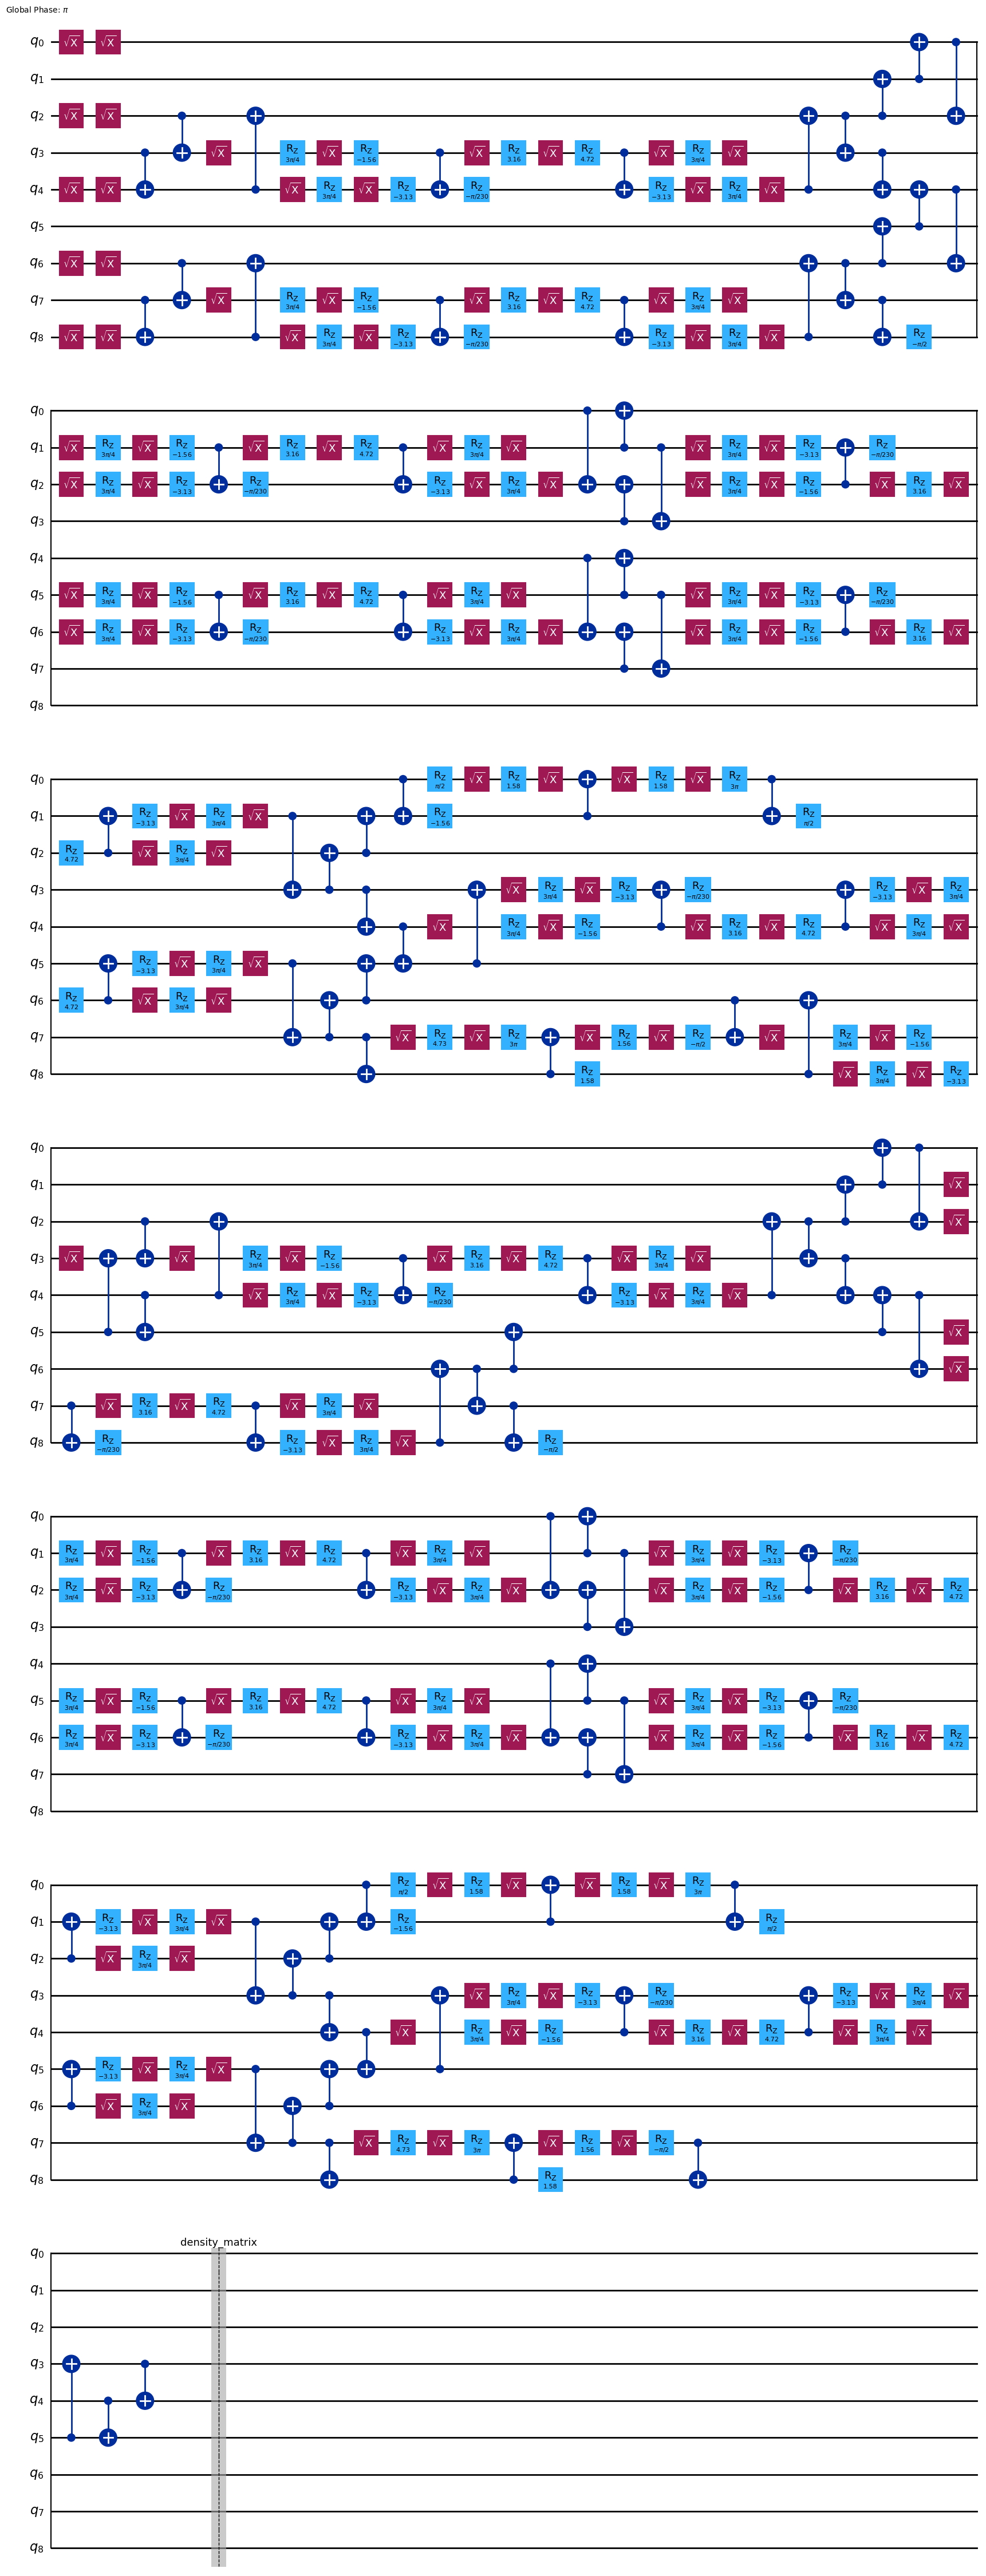

In [10]:
qc = QuantumCircuit(num_qubits)

# Prepare initial state
qc.compose(gate_initial_state(state_initial=state_initial),
            qubits=list(range(num_qubits)),
            inplace=True,)

qc.append(instruction=gate_path_triangle_parallel(num_qubits=num_qubits,
                                            num_steps=2, ###!
                                            dt=dt,
                                            type_H_eff=type_H_eff_triangle,
                                            to_instruction=False,
                                            add_barrier=False,
                                        ),
            qargs=list(range(num_qubits)),
            )

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
qc = qc.assign_parameters({dt: time_evolution / num_steps})
qc_t3 = transpile(RemoveBarriers()(qc), optimization_level=3, basis_gates=["sx", "cx", "rz"])
# qc_t3 = transpile(qc, optimization_level=3, basis_gates=["sx", "cx", "rz"])
qc_t3.save_density_matrix()
print(qc_t3.count_ops().get("cx"))
qc_t3.draw("mpl")